In [1]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np

# visualization tools
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
#supress warning for matplotlib
import warnings
warnings.filterwarnings("ignore")
import networkx as nx


In [2]:
def QAOA_circuit_vis(graph, depth_tot):
    """Provides the QAOA Circuit ansatz of any depth (assuming full connectivity)
    for a MaxCut instance and the MaxCut graph itself, purely for visualization"""
    
    # Map nodes to qubits 1:1, crearte variables for circuit & total params
    qubits = cirq.GridQubit.rect(1, len(graph.nodes))
    qaoa_circuit = cirq.Circuit()
    qaoa_params = []

    # Initial Hadamard transform 
    for qubit in qubits:
        qaoa_circuit += cirq.H(qubit)
    
    # Create a parameter set
    for depth in range(depth_tot):
        qaoa_params.append(sympy.Symbol("gamma_{}".format(depth)))
    
        # Create {H_C, H_M} alternating depth_tot times 
        for edge in graph.edges():
            qaoa_circuit += cirq.CNOT(qubits[edge[0]], qubits[edge[1]])
            qaoa_circuit += cirq.rz(1 * qaoa_params[-1])(qubits[edge[1]])
            qaoa_circuit += cirq.CNOT(qubits[edge[0]], qubits[edge[1]]) 

        qaoa_params.append(sympy.Symbol("beta_{}".format(depth)))
        cost_ham = cirq.Moment([])
        for node in graph.nodes():
            cost_ham += cirq.rx(2 * qaoa_params[-1])(qubits[node])
        qaoa_circuit.append(cost_ham)

        #Draw physical graph w/ nodes relabelled to agree with QAOA circuit 
    sorted(graph)
    mapping = {}
    for node in sorted(graph.nodes()):
        mapping[node] = '(0,' + str(node) + ')'
    graph_new = nx.relabel_nodes(graph, mapping)
    plt.figure()
    plt.title('{}-node, MaxCut Graph'.format(len(graph.nodes())))
    graph_plot = nx.draw_networkx(graph_new, node_size=800)
    print(graph_plot)


    return SVGCircuit(qaoa_circuit)

None


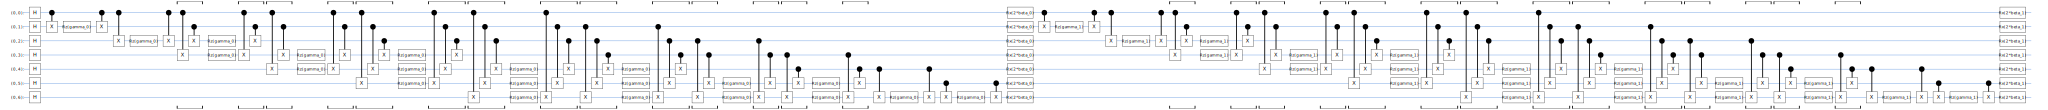

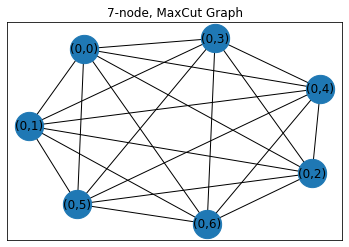

In [4]:
maxcut_graph = nx.gnp_random_graph(n=7,p=1)
QAOA_circuit_vis(maxcut_graph, 2)

In [5]:
def QAOA_circuit_vis(graph, depth_tot):
    """Provides the QAOA Circuit ansatz of any depth (assuming full connectivity)
    for a MaxCut instance and the MaxCut graph itself, purely for visualization"""
    
    qubits = cirq.GridQubit.rect(1, len(graph.nodes))
    qaoa_circuit = cirq.Circuit()
    qaoa_params = []
    
    # Initial Hadamard transform 
    for qubit in qubits:
        qaoa_circuit += cirq.H(qubit)
    
    # Create a parameter set
    for depth in range(depth_tot):
        qaoa_params.append(sympy.Symbol("gamma_{}".format(depth)))
    
        # Create {H_C, H_M} alternating depth_tot times 
        for edge in graph.edges():
            qaoa_circuit += cirq.ZZ(qubits[edge[0]], qubits[edge[1]])**qaoa_params[-1]
            
        qaoa_params.append(sympy.Symbol("beta_{}".format(depth)))
        cost_ham = cirq.Moment([])
        for node in graph.nodes():
            cost_ham += (cirq.X(qubits[node])**qaoa_params[-1])
        qaoa_circuit.append(cost_ham)
    
    # Draw physical graph w/ nodes relabelled to agree with QAOA circuit 
    sorted(graph)
    mapping = {}
    for node in sorted(graph.nodes()):
        mapping[node] = '(0,' + str(node) + ')'
    graph_new = nx.relabel_nodes(graph, mapping)
    plt.figure()
    plt.title('{}-node, regular MaxCut Graph'.format(len(graph.nodes())))
    graph_plot = nx.draw_networkx(graph_new, node_size=800)
    print(graph_plot)
    
    return SVGCircuit(qaoa_circuit)

None


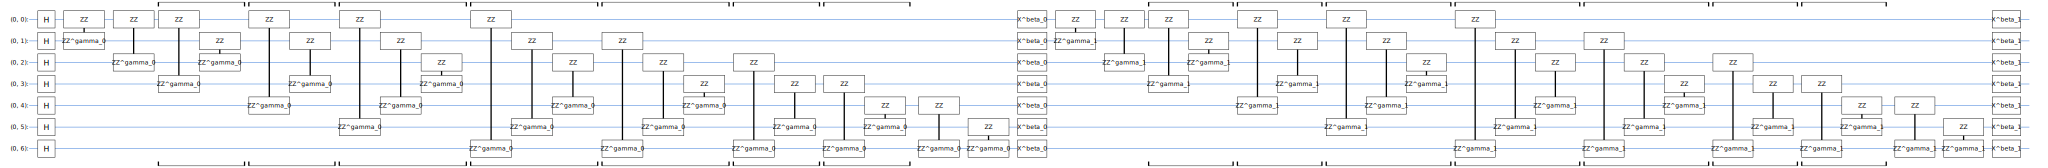

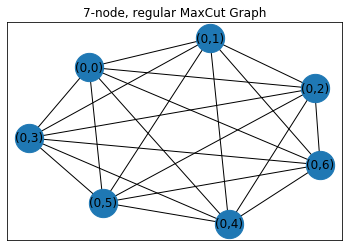

In [6]:
maxcut_graph = nx.gnp_random_graph(n=7,p=1)
QAOA_circuit_vis(maxcut_graph, 2)

In [7]:
def maxcut_qaoa_TFQ_model(graph, depth_tot):
    """Takes in a unweighted, n-node regular or irregular MaxCut graph, maps it to a QAOA circuit (assuming full hardware connectivity), 
    and creates TFQ model for it"""
    
    # Map nodes to qubits 1:1, crearte variables for circuit & total params
    qubits = cirq.GridQubit.rect(1, len(graph.nodes))
    qaoa_circuit = cirq.Circuit()
    qaoa_params = []
    
    # Create a parameter set
    for depth in range(depth_tot):
        qaoa_params.append(sympy.Symbol("gamma_{}".format(depth)))
    
        # Create {H_C, H_M} alternating depth_tot times 
        for edge in graph.edges():
            qaoa_circuit += cirq.CNOT(qubits[edge[0]], qubits[edge[1]])
            qaoa_circuit += cirq.rz(1 * qaoa_params[-1])(qubits[edge[1]])
            qaoa_circuit += cirq.CNOT(qubits[edge[0]], qubits[edge[1]]) 
            
        qaoa_params.append(sympy.Symbol("beta_{}".format(depth)))
        for node in graph.nodes():
            qaoa_circuit += cirq.rx(2 * qaoa_params[-1])(qubits[node])
            
    # Define the H_c to pass into tfq.layers.PQC as measurement operator?
    cost_op = None
    for edge in graph.edges():
        if cost_op is None:
            cost_op = cirq.Z(qubits[edge[0]])*cirq.Z(qubits[edge[1]])
        else:
            cost_op += cirq.Z(qubits[edge[0]])*cirq.Z(qubits[edge[1]])
        
    """Use qaoa_circuit, cost_op, hadamard_circuit for model to create the TFQ model"""
    
    # Input will be initial superposition (hadamard transform)
    hadamard_transform = cirq.Circuit()
    for q in qubits:
        hadamard_transform += cirq.H(q)
    model_input = tfq.convert_to_tensor([hadamard_transform])

    
    # Construct model layers/architecture
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string))
    model.add(tfq.layers.PQC(qaoa_circuit, cost_op))
    
    # Provide elements needed to train/fit model
    return model, model_input, qaoa_params, qaoa_circuit

In [8]:
# Create the graph
graph_1 = nx.random_regular_graph(n=4, d=2)

# Create the TFQ model components for graph_1 at p=1 depth
model, model_input, graph_1_params, qaoa_circuit = maxcut_qaoa_TFQ_model(graph_1, 1)
print(model.summary(), model_input, graph_1_params)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
None tf.Tensor([b'\n\x0e\n\x0ctfq_gate_set\x12\xe9\x02\x08\x01\x12\xe4\x02\nW\n\x04\n\x02HP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x1a\x05\x12\x030_0\nW\n\x04\n\x02HP\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x1a\x05\x12\x030_1\nW\n\x04\n\x02HP\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\

In [9]:
# Define optimum for loss
optimum = [0]
optimum = np.array(optimum)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss=tf.keras.losses.mean_squared_error)

In [10]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss=tf.keras.losses.mean_squared_error)


In [11]:
# Create an early stopping mechanism
callback_strat = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0.003, patience=0, verbose=1)


In [12]:
# Train model
history = model.fit(model_input, optimum, epochs=20, verbose=1)

Train on 1 samples
Epoch 1/20
1/1 [==============================] - 8s 8s/sample


InvalidArgumentError:  Expected 2 inputs, got -1534595007 inputs.
	 [[node sequential/pqc/add_circuit/TfqAppendCircuit (defined at /Users/nicocolomacook/opt/anaconda3/envs/TFQenv/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_distributed_function_1089]

Function call stack:
distributed_function


In [ ]:
# View performance
plt.plot(history.history['loss'])
plt.title("QAOA Parameter Optimization with TFQ")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
#plt.show()

In [ ]:
# Use the model for prediction (model.predict())
# Read out the optimal parameters
opt_params = model.trainable_variables
print(opt_params)

In [ ]:
# Create a circuit and sample bitstrings from the final state 1000 times, can create in Cirq, TFQ
add = tfq.layers.AddCircuit() 
output_circuit_tensor = add(model_input, append=qaoa_circuit)
sample_layer = tfq.layers.Sample()
output_bitstrings = sample_layer(output_circuit_tensor,  symbol_names= graph_1_params, symbol_values= opt_params, repetitions=1000)

In [ ]:
# Converting the output_bitstrings from ragged tensor -> tensor -> np 2D array 
out1 = output_bitstrings[0].to_tensor()
bitstrings_all = np.array(out1.numpy())
print("NumPy array of sampled output:\n", bitstrings_all[:5])

# Joining the bits for the 4 qubits, list now has str elements
new_bitstrings = []
for item in bitstrings_all:
    joined_bitstring = ''.join(map(str, item))
    new_bitstrings.append(joined_bitstring)

print("\nBitstrings joined (1D array) but now as strings: ", new_bitstrings[:5], type(new_bitstrings[0]))

# Converting elements in list from str to int
# Note: Issue is that you need to figure out how to keep ALL significant figures 
bit_list_2 = list(map(int, new_bitstrings[:5]))
print("\nBitstrings converted int using map method:", bit_list_2, type(bit_list_2))

new_int_list = []
for element in new_bitstrings:
    bit_binary = int(element, 2)
    new_int_list.append(bit_binary)

# Could technically just use this for histogram
print("Converted binary strings to ints: ", new_int_list[:5])

# Unitary definitions
$\prod_{p=1}^{m}$